In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from functools import partial

from plotly.subplots import make_subplots
import statsmodels.api as sm
import scipy.signal as signal

import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

from utils import optimizer as opt


In [2]:
def distance_weighted(x,y,mu):
    return np.sum(np.array(mu)*(x-y)**2)

def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


### Preprocessing

In [3]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')

In [4]:
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})
train_data["Normal/Attack"].value_counts()
data_np = train_data.drop(columns = ["Unnamed: 0","Normal/Attack", " Timestamp"]).values

In [5]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(data_np)

In [16]:
# Create a PCA instance
n_components_analysis = 20
pca = PCA(n_components = n_components_analysis)

# Fit the data and transform it
data_pca = pca.fit_transform(df_scaled)

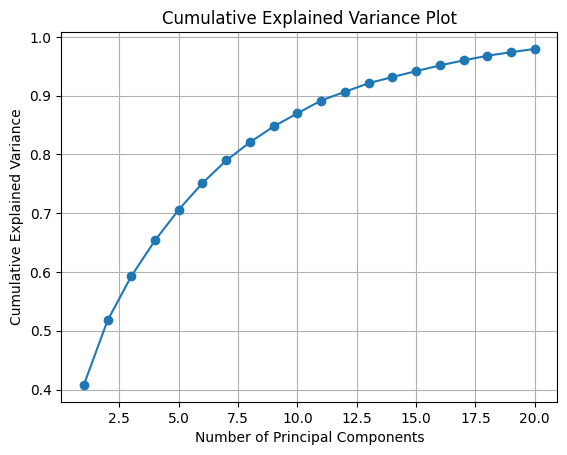

[0.40783483 0.51749147 0.5927148  0.65373156 0.70592446 0.75118774
 0.78960598 0.82056035 0.84753422 0.86981606 0.89157828 0.9064483
 0.92098476 0.93151042 0.94159047 0.95125386 0.95984561 0.96774067
 0.97381102 0.97937024]


In [17]:
# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()
print(cumulative_explained_variance)

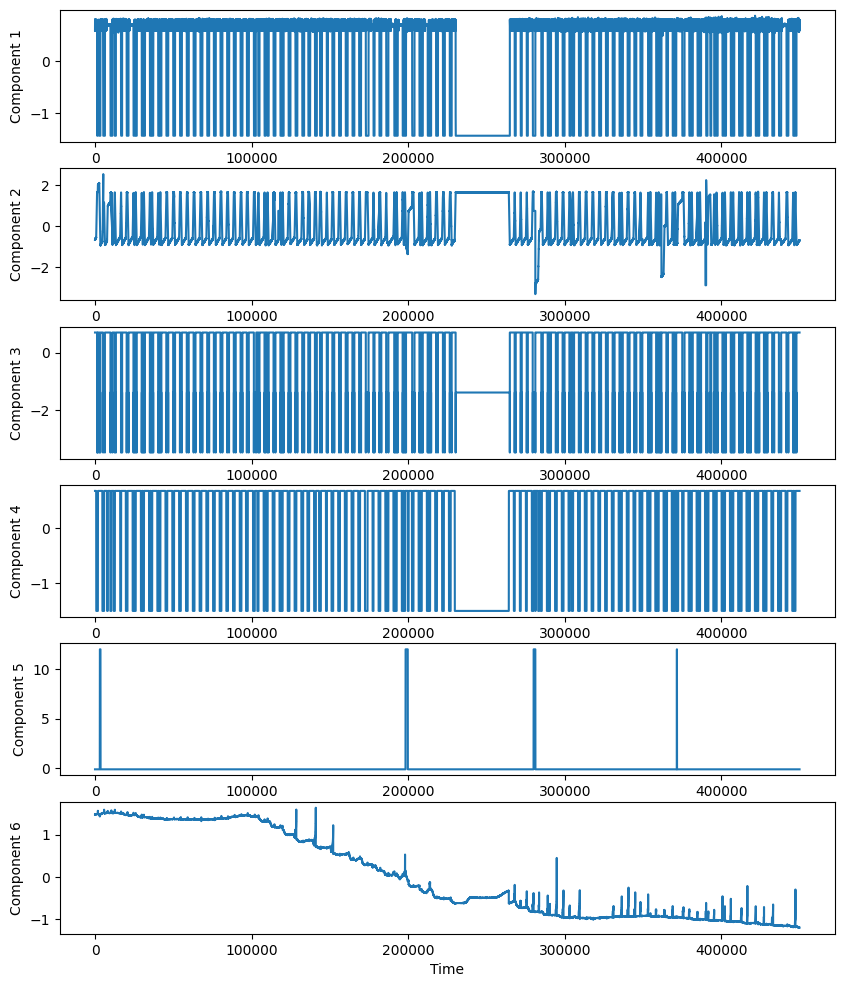

In [18]:

# Plot the first 6 components in 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 12))

for i in range(6):
    axes[i].plot(df_scaled[:, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

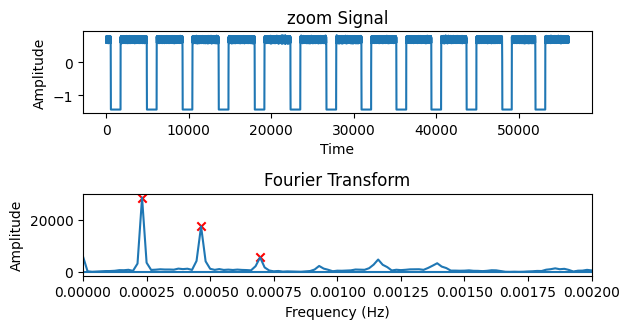

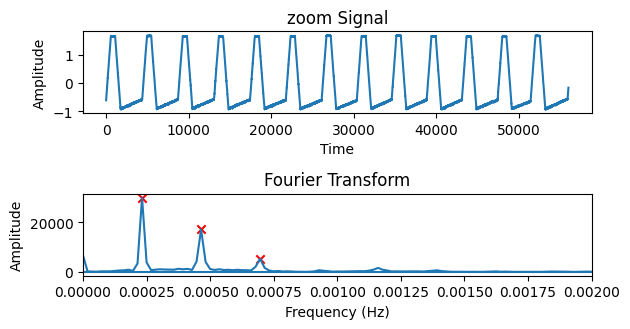

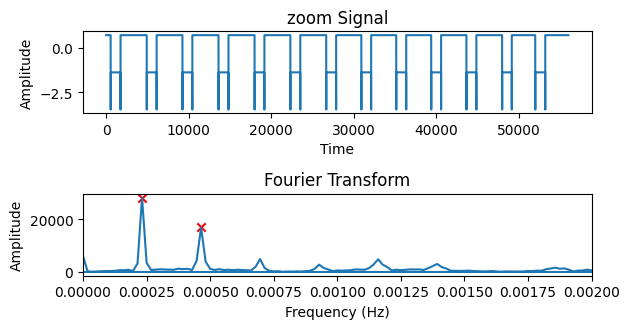

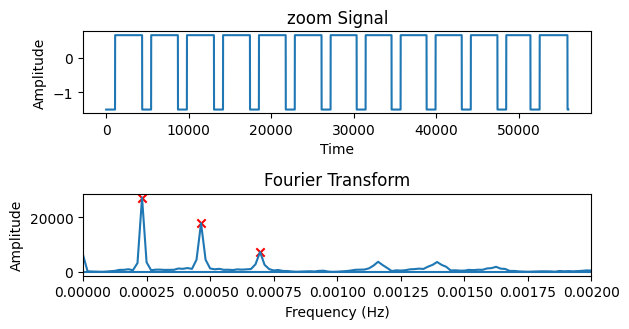

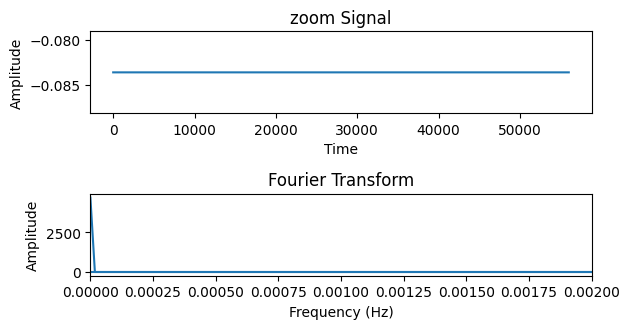

In [8]:
n_components = 5
periodicity = []
for i in range(n_components):
    signal_periodic = df_scaled[45000:101000, i]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)
    
    peaks, _ = find_peaks(np.abs(fourier_transform), height=5e3)
    periodicity.append(1/frequencies[peaks[:3]])

    plt.subplot(3, 1, 2)
    plt.plot( signal_periodic)
    plt.title('zoom Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    plt.title('Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0,0.002)
    plt.tight_layout()
    plt.show()


In [9]:
periodicity

[array([4307.69230769, 2153.84615385, 1435.8974359 ]),
 array([4307.69230769, 2153.84615385, 1435.8974359 ]),
 array([ 4307.69230769,  2153.84615385, -2153.84615385]),
 array([4307.69230769, 2153.84615385, 1435.8974359 ]),
 array([], dtype=float64)]

In [10]:
main_periodicity = periodicity[0][0]
print("Main periodicity in seconds", main_periodicity)
downsampling_rate = int(main_periodicity/40)
print("Downsampling rate", downsampling_rate)

Main periodicity in seconds 4307.692307692308
Downsampling rate 107


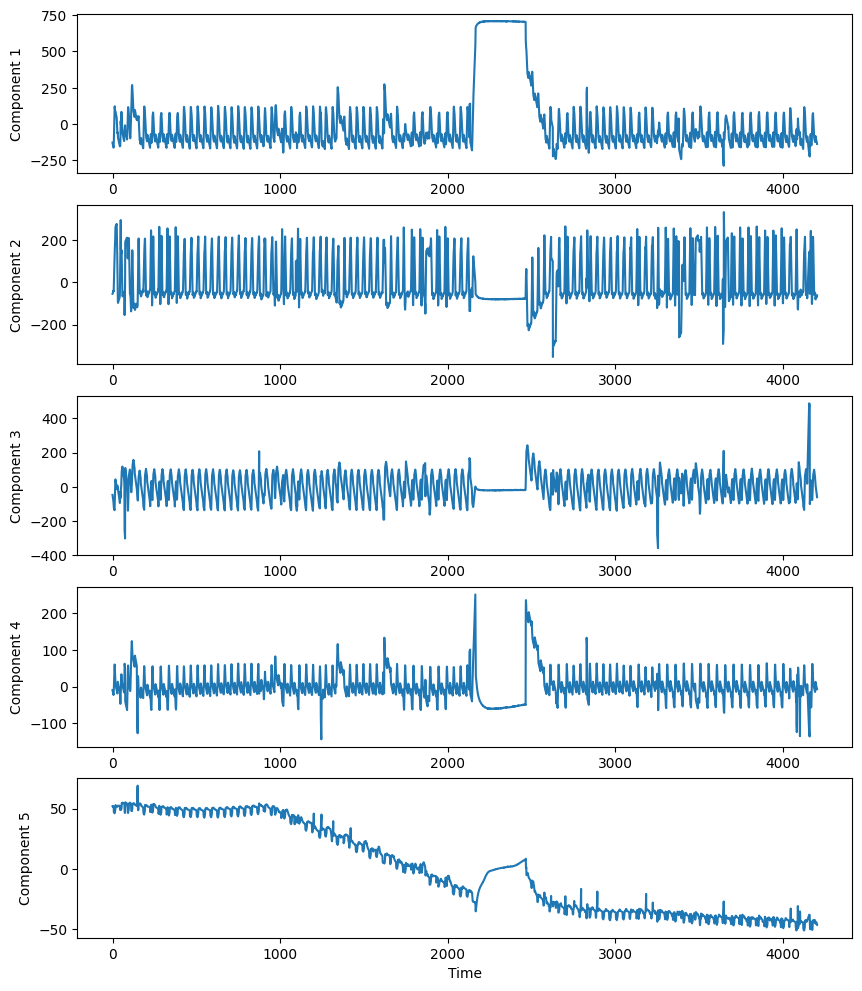

In [10]:
### Downsample the data 

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca[::downsampling_rate, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

### Anomaly detection

#### Generate subsequences for shapes and amplitudes

In [11]:

window_size = int(main_periodicity/downsampling_rate)
#index_to_keep = [0,1,5,6,7,8,16,17,18,25,26,27,28,34,35,36,37,38,39,40,41,44,45,46,47]
stride =int(window_size/5)
sequences = generate_subsequences(df_scaled[::downsampling_rate], window_size, stride)
label_sequences = generate_subsequences(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  40
stride =  8


In [174]:
sequences_acf = np.zeros_like(sequences)

In [85]:
sequences_copy = sequences.copy()

for i in range(sequences_copy.shape[0]):
    for j in range(sequences_copy.shape[2]):

        # check if all values are the same
        if np.all(sequences_copy[i, :, j] == sequences_copy[i, 0, j]):
            sequences_copy[i, 0, j] += 0.0001
            # print("warning: constant timeseries")
            
        sequences_acf[i, :, j] = sm.tsa.acf(
            sequences_copy[i, :, j], nlags=len(sequences_copy[i, :, j]) - 1
        )

# sequences_acf[np.isnan(sequences_acf)] = sequences[np.isnan(sequences_acf)]

In [86]:

data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

In [260]:
train_data.columns

Index(['Unnamed: 0', ' Timestamp', 'FIT101', 'LIT101', ' MV101', 'P101',
       'P102', ' AIT201', 'AIT202', 'AIT203', 'FIT201', ' MV201', ' P201',
       ' P202', 'P203', ' P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', ' MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602',
       'P603', 'Normal/Attack'],
      dtype='object')

#### Fuzzy C-Means on amplitude using naive mu

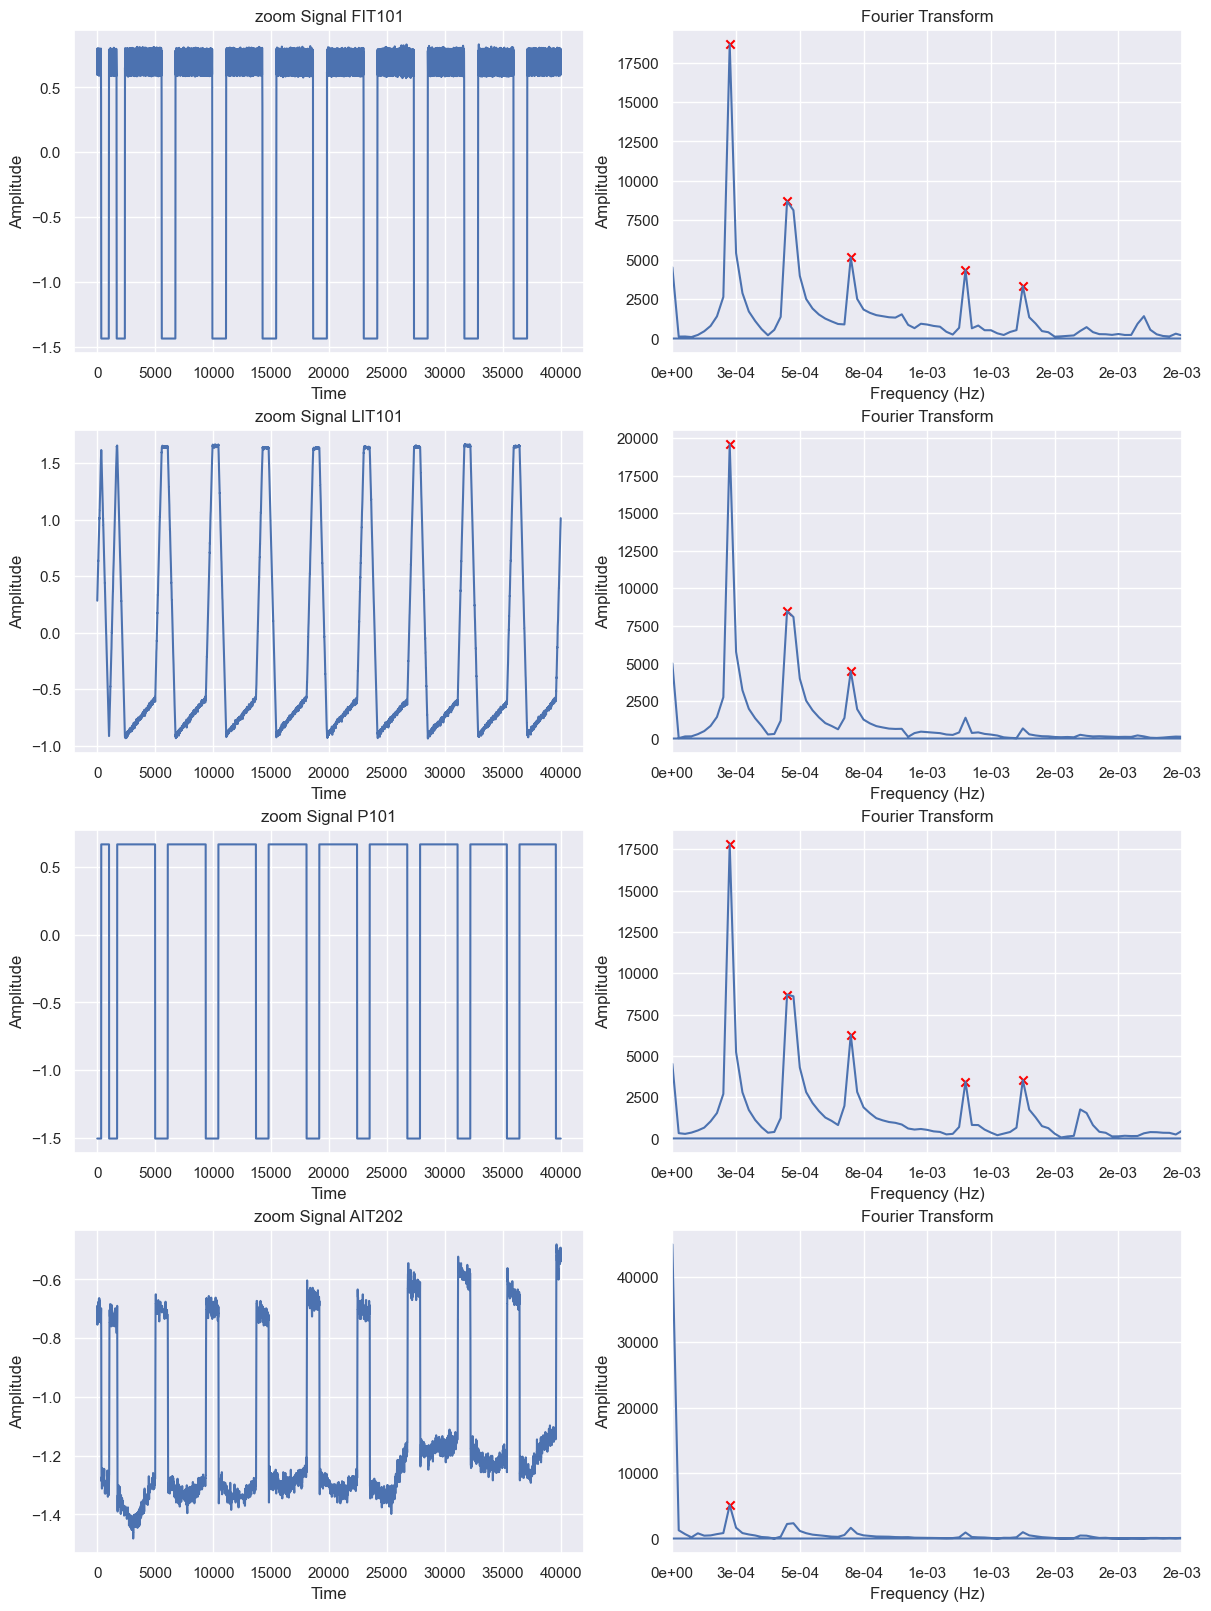

In [258]:
index_to_keep = [0,1,5,6,7,8,16,17,18,25,26,27,28,34,35,36,37,38,39,40,41,44,45,46,47]
idx = [0,1,3, 6, 7]
fig, axs = plt.subplots(4, 2, figsize=(12, 16), constrained_layout=True)
import matplotlib.ticker as ticker

for i,index in enumerate(idx[:4]):
    signal_periodic = df_scaled[::, index][40000:80000]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)

    peaks, _ = find_peaks(np.abs(fourier_transform), height=3000)
    periodicity.append(1/frequencies[peaks[:3]])


    axs[i,0].plot( signal_periodic)
    axs[i,0].set_title(f'zoom Signal {train_data.columns[index+2]}')
    axs[i,0].set_xlabel('Time')
    axs[i,0].set_ylabel('Amplitude')

    
    axs[i,1].plot(frequencies, np.abs(fourier_transform))
    axs[i,1].scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    axs[i,1].set_title('Fourier Transform')
    axs[i,1].set_xlabel('Frequency (Hz)')
    axs[i,1].set_ylabel('Amplitude')
    axs[i,1].set_xlim(-0.00000001,0.002)
    axs[i, 1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))




In [40]:
loss_list = []

data_for_clustering = sequences.reshape(sequences.shape[0], -1)
mu = np.random.random(data_for_clustering.shape[1])
mu = mu/np.sum(mu)
#mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]
mu= data[6]['list_mu']
mu = np.repeat(mu, window_size)
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    4, # N cluster
    2, # fuzzy coef
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
loss = reconstructed_loss(reconstructed_points, data_for_clustering)
loss_list.append(loss)

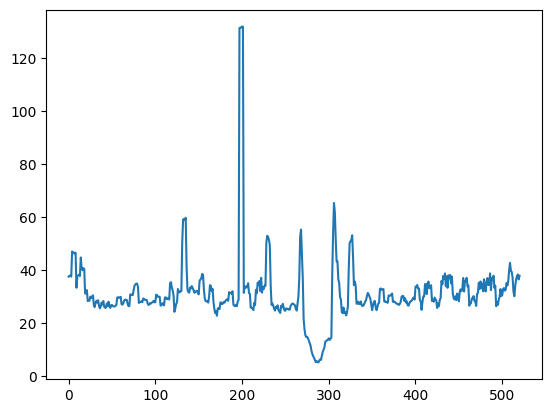

In [41]:
plt.plot(loss)

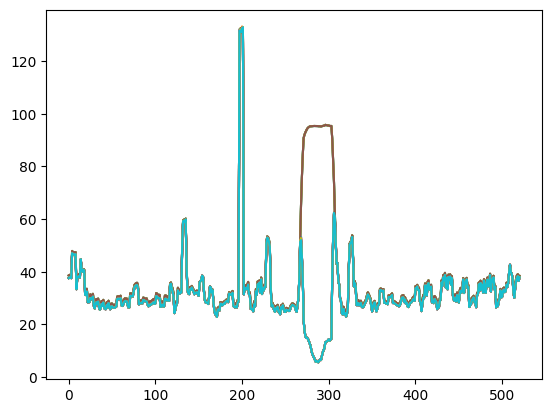

In [20]:
for i in range(20):
    plt.plot(loss_list[i])

In [14]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

(0.0, 10.0)

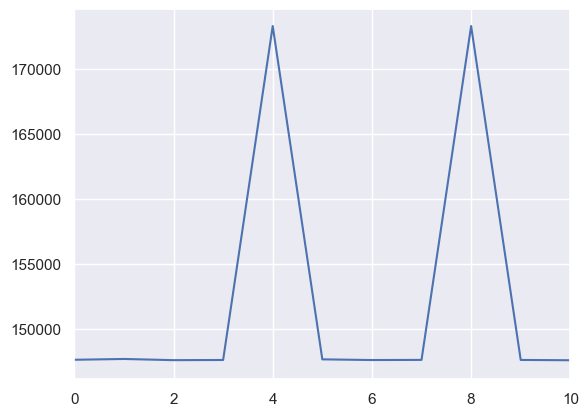

In [97]:
loss_sum = [np.sum(total_loss_pso[i]) for i in range(len(total_loss_pso))]
plt.plot(loss_sum)
plt.xlim(0,10)

In [133]:
loss = total_loss_pso_amplitude[0]
loss_otpimzied = total_loss_pso_amplitude[6]
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss naive"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(loss_otpimzied)), y=loss_otpimzied, mode="lines", name="Loss optimized"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)


fig

In [134]:
loss = total_loss_pso[0]
loss_otpimzied = total_loss_pso[-1]
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss step 0"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss_otpimzied[label_1_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(loss_otpimzied)), y=loss_otpimzied, mode="lines", name="Loss optimized"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)


fig

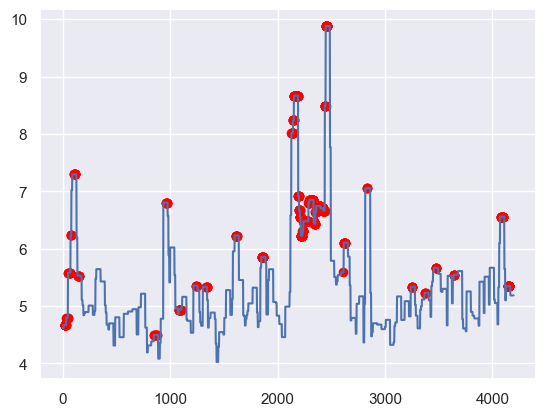

In [84]:
label_1_indices = np.where(labels == 1)[0]
plt.plot(total_loss_pso[0])
plt.scatter(label_1_indices, total_loss_pso[0][label_1_indices], color='red', label='Local Maxima')

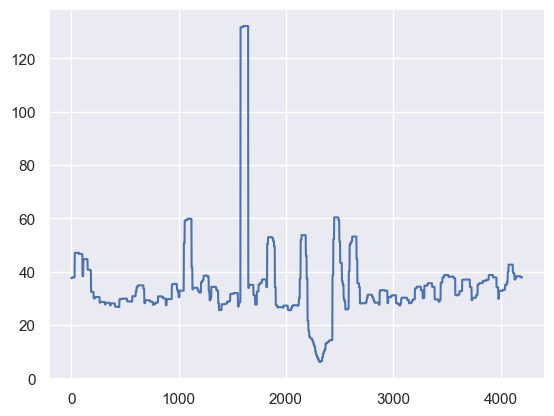

In [148]:
plt.plot(total_loss_pso_amplitude[1]) 

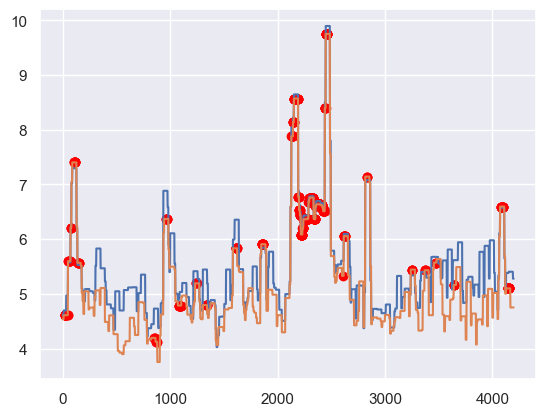

In [122]:
plt.plot(total_loss_pso[0]) 
plt.plot(total_loss_pso[-1])
plt.scatter(label_1_indices, total_loss_pso[-1][label_1_indices], color='red', label='Local Maxima')

In [149]:
from evaluator import TSEvaluator
threshold = np.arange(5,140,0.5)
labels = train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate]
recall_naive = []
recall_1_naive = []
precision_naive = []

for thres in threshold:
    print(thres)
    #loss = upscale_signal(total_loss, labels.shape[0], stride, window_size, operator=np.maximum)
    predicted_labels = total_loss_pso_amplitude[1] > thres
    evaluator = TSEvaluator(alpha_recall = 0)
    recall_naive.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels))
    precision_naive.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels))
    evaluator = TSEvaluator(alpha_recall = 1)
    recall_1_naive.append(evaluator.get_recall(labels, predicted_labels ))


5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5
25.0
25.5
26.0
26.5
27.0
27.5
28.0
28.5
29.0
29.5
30.0
30.5
31.0
31.5
32.0
32.5
33.0
33.5
34.0
34.5
35.0
35.5
36.0
36.5
37.0
37.5
38.0
38.5
39.0
39.5
40.0
40.5
41.0
41.5
42.0
42.5
43.0
43.5
44.0
44.5
45.0
45.5
46.0
46.5
47.0
47.5
48.0
48.5
49.0
49.5
50.0
50.5
51.0
51.5
52.0
52.5
53.0
53.5
54.0
54.5
55.0
55.5
56.0
56.5
57.0
57.5
58.0
58.5
59.0
59.5
60.0
60.5
61.0
61.5
62.0
62.5
63.0
63.5
64.0
64.5
65.0
65.5
66.0
66.5
67.0
67.5
68.0
68.5
69.0
69.5
70.0
70.5
71.0
71.5
72.0
72.5
73.0
73.5
74.0
74.5
75.0
75.5
76.0
76.5
77.0
77.5
78.0
78.5
79.0
79.5
80.0
80.5
81.0
81.5
82.0
82.5
83.0
83.5
84.0
84.5
85.0
85.5
86.0
86.5
87.0
87.5
88.0
88.5
89.0
89.5
90.0
90.5
91.0
91.5
92.0
92.5
93.0
93.5
94.0
94.5
95.0
95.5
96.0
96.5
97.0
97.5
98.0
98.5
99.0
99.5
100.0
100.5
101.0
101.5
102.0
102.5
103.0
103.5
104.0
104.5


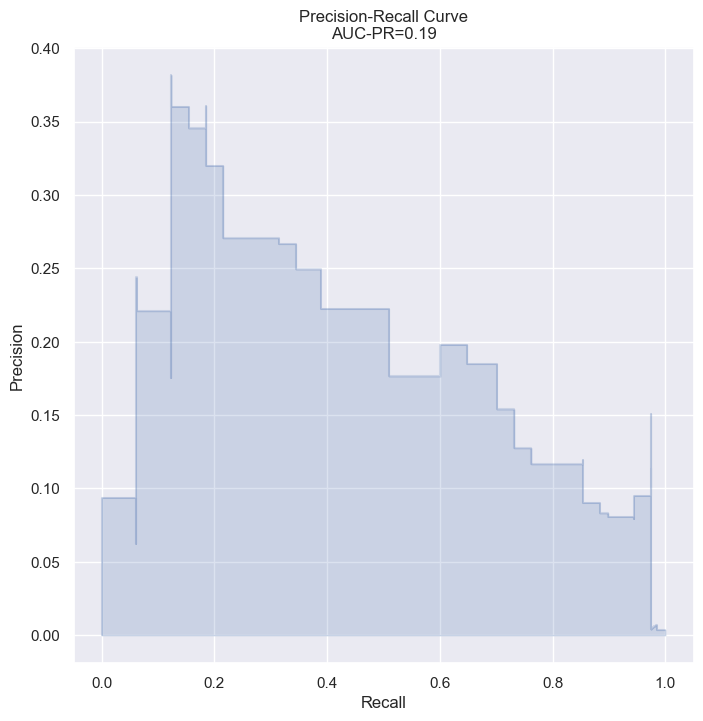

In [150]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive, precision_naive)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive, precision_naive, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive, precision_naive, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()

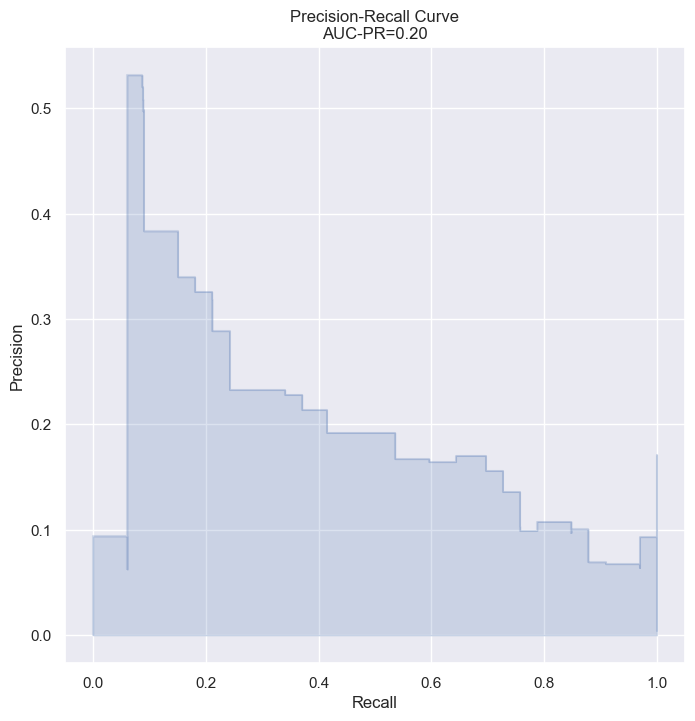

In [145]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive, precision_naive)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive, precision_naive, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive, precision_naive, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()

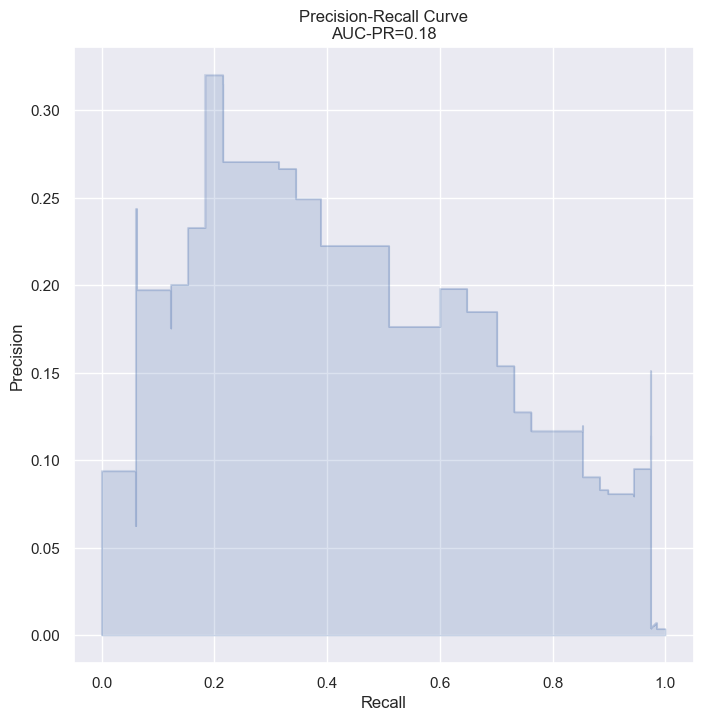

In [139]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive, precision_naive)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive, precision_naive, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive, precision_naive, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()


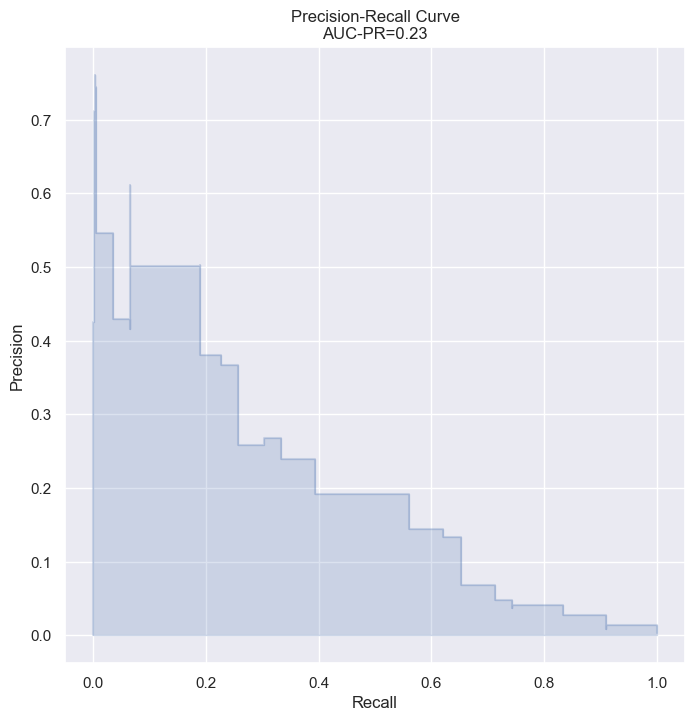

In [124]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive_, precision_naive_)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive_, precision_naive_, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive_, precision_naive_, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()


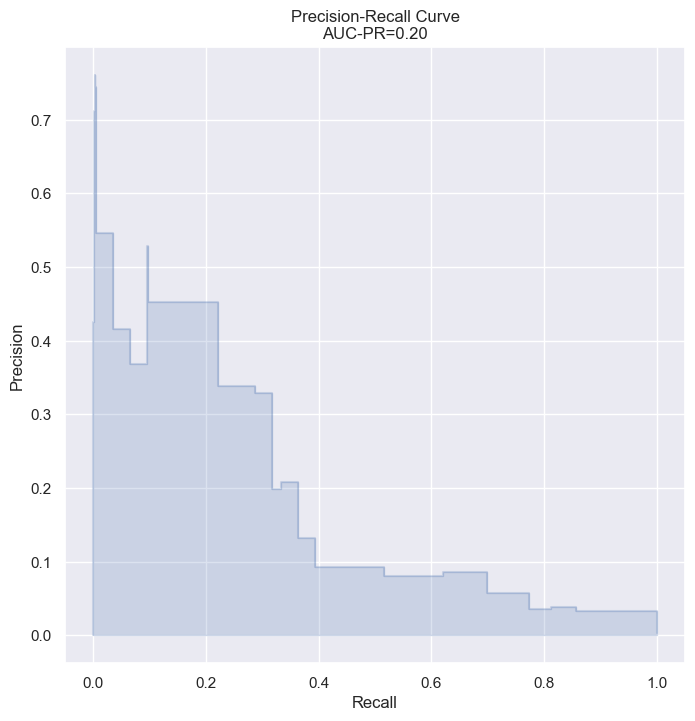

In [126]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive_, precision_naive_)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive_, precision_naive_, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive_, precision_naive_, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()


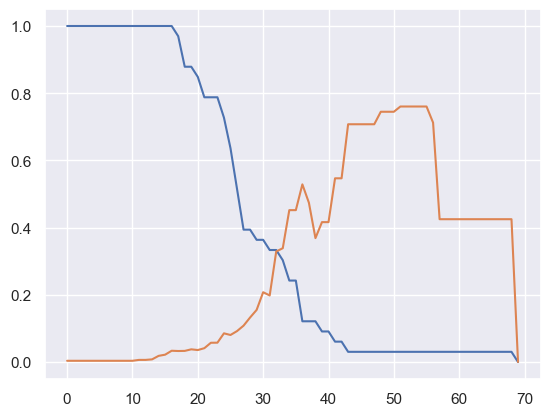

In [129]:
plt.plot(recall_1_naive_)
plt.plot(precision_naive_)

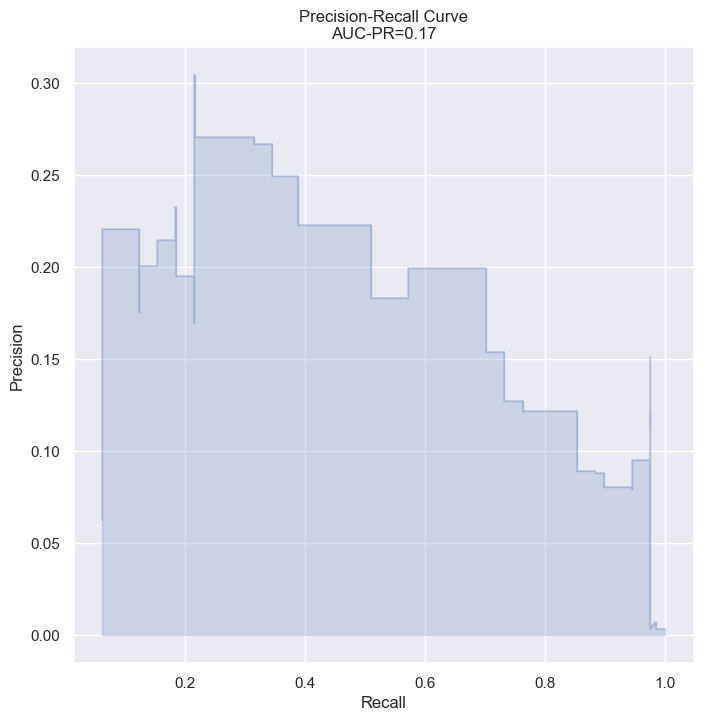

In [114]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive_, precision_naive_)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive_, precision_naive_, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive_, precision_naive_, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()


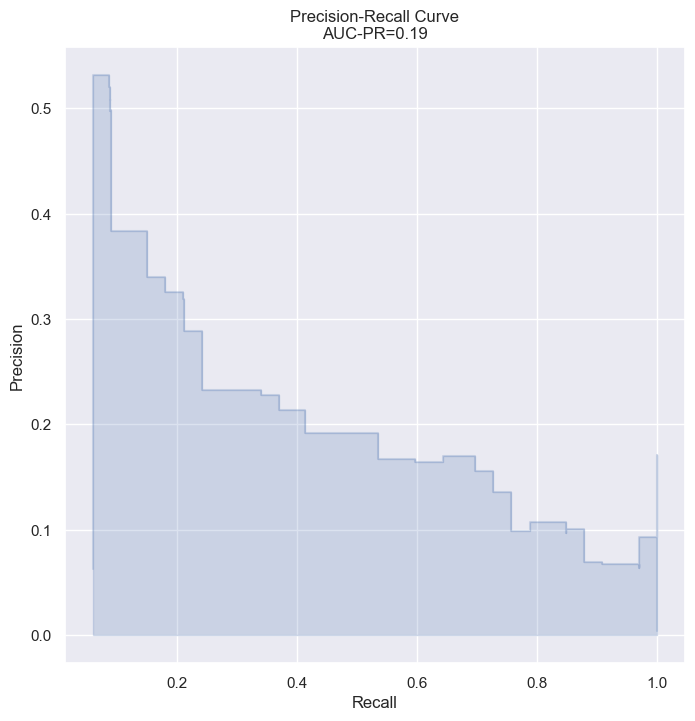

In [109]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
# Compute AUC-PR
auc_pr = auc(recall_naive_, precision_naive_)

# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_naive_, precision_naive_, color='b', alpha=0.2, where='post')
plt.fill_between(recall_naive_, precision_naive_, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\nAUC-PR={auc_pr:.2f}')
plt.show()


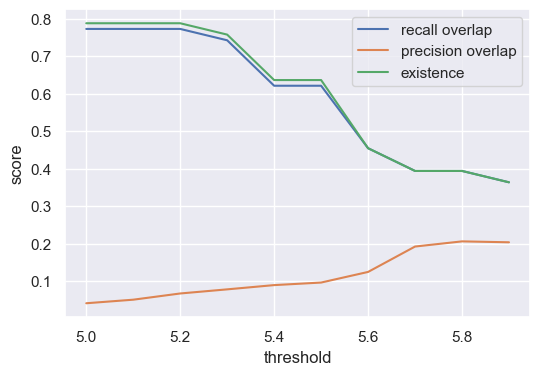

In [81]:
import seaborn as sns
sns.set()
plt.figure(figsize=(6,4))
# plt.plot(threshold, recall, label = "recall overlap reward")
# plt.plot(threshold, precision, label = "precision overlap reward")
# plt.plot(threshold, recall_1, label = "existence reward")
# plt.plot(threshold, recall_naive, label = "recall overlap naive")
# plt.plot(threshold, precision_naive, label = "precision overlap naive")
# plt.plot(threshold, recall_1_naive, label = "existence naive")
plt.plot(threshold, recall_naive_, label = "recall overlap")
plt.plot(threshold, precision_naive_, label = "precision overlap")
plt.plot(threshold, recall_1_naive_, label = "existence")
plt.xlabel("threshold")
plt.ylabel("score")
plt.legend()

#### Fuzzy C-means on shapes with ACF

In [82]:
mu = [
    1 / data_for_clustering_shapes.shape[1]
    for i in range(data_for_clustering_shapes.shape[1])
]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering_shapes.T,
    3,  # N cluster
    2,  # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

NameError: name 'data_for_clustering_shapes' is not defined

In [20]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering_shapes)

In [21]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Optimization

In [23]:

N_cluster = 2
model = "amplitude"

if model == "amplitude":
    data_for_clustering_opt = data_for_clustering

else:
    data_for_clustering_opt = data_for_clustering_shapes

algorithm_param = {
    "max_num_iteration": 20,
    "population_size": 20,
    "mutation_probability": 0.1,
    "elit_ratio": 0.05,
    "crossover_probability": 0.5,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

In [24]:
optimizer = opt(
    N_cluster=N_cluster,
    data=data_for_clustering_opt,
    window_size=window_size,
    ga_opt_parameters=algorithm_param,
)

In [25]:
optimizer.run_ga()

||||||||||||||||||||||____________________________ 45.0% GA is running...

KeyboardInterrupt: 

In [33]:
optimizer.run_pso(max_iter=20, initial_particles = [50,100])

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
convergence_ga = optimizer.convergence_ga
solution_ga = optimizer.solution_ga
fitness_pso = optimizer.fitness_pso
solution_pso = optimizer.solution_pso

print(f"ga: {convergence_ga[-1]}, pso : {fitness_pso}")

ga: 512150.57040038647, pso : 512048.3539002576


In [ ]:
print(f"ga: {solution_ga['variable']}, \n pso : {solution_pso}")

ga: [0.43241759 0.49711708 0.00653132 0.25517654 0.49993477], 
 pso : [ 46.56782264 153.04942333   0.           0.         127.4180994 ]


In [ ]:
# optimizer.dict_opt_save
# optimizer.dict_opt_save_pso

In [ ]:
solution = solution_ga

### Use the optimization result to run the reconstruction loss

In [ ]:
opt_mu = solution["variable"]
win_len = data_for_clustering_opt.shape[1] // len(opt_mu)

opt_mu = opt_mu / opt_mu.sum()  # normalize the coefficients
opt_mu = np.repeat(opt_mu, win_len)

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_for_clustering_opt.T,
    N_cluster, # N cluster
    2, #
    metric=partial(distance_weighted, mu=opt_mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
opt_reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [ ]:
opt_loss = reconstructed_loss(opt_reconstructed_points, data_for_clustering_opt)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(opt_loss)), y=opt_loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=opt_loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Metric : combining the subsequences to calculate a score on the og TS

In [21]:
def upscale_signal(subsequences, original_size, stride, window_length, operator=np.maximum):
    upscaled_signal = np.zeros(original_size)  # Initialize upscaled signal array

    for i, subsequence in enumerate(subsequences):
        start_index = i * stride
        end_index = start_index + window_length
        upscaled_signal[start_index:end_index] = operator(upscaled_signal[start_index:end_index], subsequence)

    return upscaled_signal[upscaled_signal > 0]

# data_pca_reduced_downsampled = data_pca_reduced[::downsampling_rate].copy()
# total_loss = upscale_signal(opt_loss, data_pca_reduced_downsampled.shape[0], stride, window_size, operator=np.maximum)

In [ ]:
fig = go.Figure()

temp = np.where(train_data["Normal/Attack"][::downsampling_rate].values == 1)[0]

fig.add_trace(go.Scatter(x=np.arange(len(total_loss)), y=total_loss, mode="lines", name="opt Loss"))
fig.add_trace(
    go.Scatter(
        x=temp, y=total_loss[temp], mode="markers", name="Attack"
    )
)

fig

### Evaluation

In [41]:
import pickle
from evaluator import TSEvaluator
data_names = ["2_dict_opt_save_pso.pkl", "2_dict_opt_save.pkl", "3_dict_opt_save.pkl", "3_dict_opt_save_pso.pkl"]

for data_name in data_names:
    LOSS_ACC = []
    with open("outputs/" + data_name, 'rb') as f:
        data = pickle.load(f)
        loss_accuracy = []
        for key in data.keys():
            i = 0
            for _, dict_values in data.items():
                i+=1
                print(i)
                loss_ts = dict_values["loss_ts"]
                total_loss = upscale_signal(loss_ts, data_pca_reduced_downsampled.shape[0], stride, window_size, operator=np.maximum)
                evaluator = TSEvaluator(alpha_recall = 0)
                recall = evaluator.get_recall(total_loss, train_data["Normal/Attack"][::downsampling_rate].values)
                precision = evaluator.get_precision(total_loss, train_data["Normal/Attack"][::downsampling_rate].values)
                evaluator = TSEvaluator(alpha_recall = 1)
                recall_1 = evaluator.get_recall(total_loss, train_data["Normal/Attack"][::downsampling_rate].values)
                loss_accuracy.append([dict_values["loss_sum"],recall, recall_1, precision])
    LOSS_ACC.append(loss_accuracy)
                

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [22]:
import pickle
from evaluator import TSEvaluator

labels = train_data["Normal/Attack"][::downsampling_rate].values

with open("outputs/4_dict_opt_save_pso_NOPCA_STD.pkl", 'rb') as f:
    data = pickle.load(f)
    loss_accuracy_ga = []
    i = 0
    print(len(data))
    for _, dict_values in data.items():
        i+=1
        print(i)
        loss_ts = dict_values["loss_ts"]
        loss_accuracy_ga.append([total_loss,recall, recall_1, precision])

820
1


NameError: name 'total_loss' is not defined

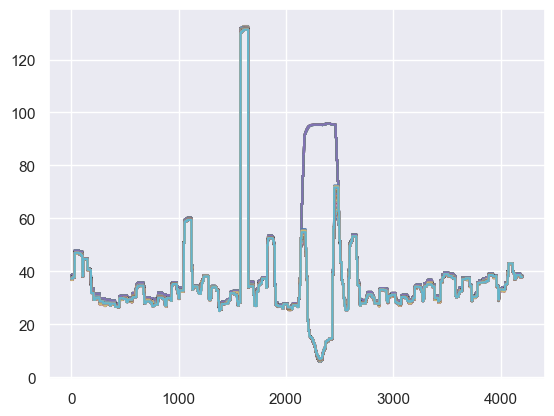

In [130]:

with open("outputs/3_dict_opt_save_pso_NOPCA_STD.pkl", 'rb') as f:
    data = pickle.load(f)
    total_loss_pso_amplitude = []
    i = 0
    for _, dict_values in data.items():
        i+=1
        loss_ts = dict_values["loss_ts"]
        total_loss = upscale_signal(loss_ts, labels.shape[0], stride, window_size, operator=np.maximum)
        total_loss_pso_amplitude.append(total_loss)
        plt.plot(total_loss)

Text(0, 0.5, 'reconstruction loss')

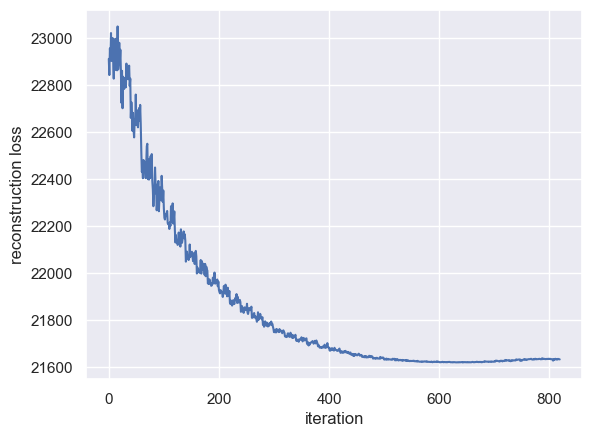

In [117]:
loss_sum = [np.sum(loss) for loss in total_loss_pso]
plt.plot(loss_sum)
plt.xlabel("iteration")
plt.ylabel("reconstruction loss")

Text(0, 0.5, 'reconstruction loss')

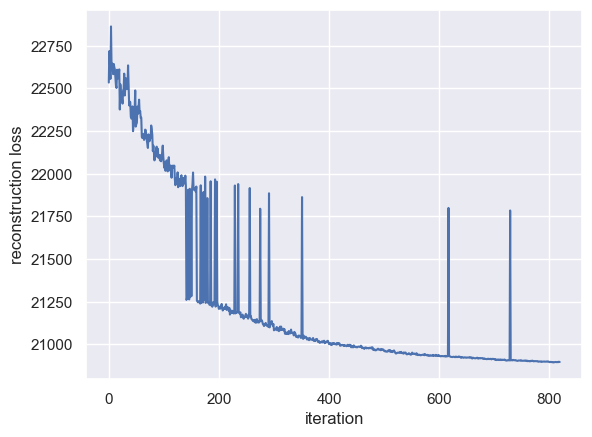

In [76]:
loss_sum = [np.sum(loss) for loss in total_loss_pso]
plt.plot(loss_sum)
plt.xlabel("iteration")
plt.ylabel("reconstruction loss")

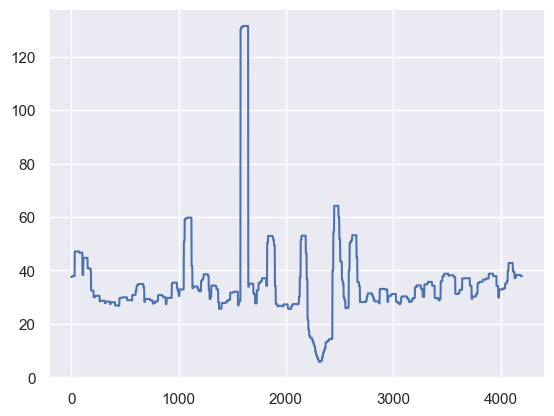

In [62]:
loss_ts = data[819]["loss_ts"]
total_loss = upscale_signal(loss_ts, labels.shape[0], stride, window_size, operator=np.maximum)
plt.plot(total_loss)

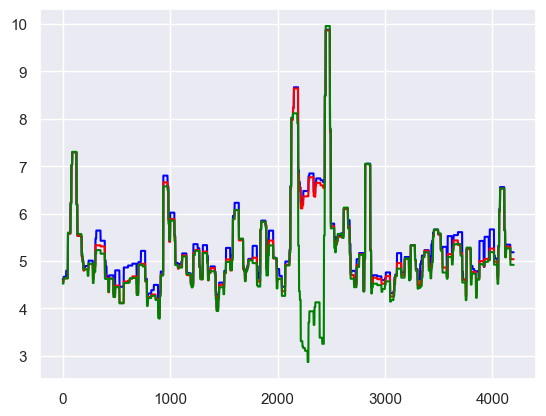

In [75]:
plt.plot(total_loss_pso[0], color = "blue")
plt.plot(total_loss_pso[100], color = "red")
plt.plot(total_loss_pso[200], color = "green")

In [27]:
loss_sum = [np.sum(loss_i) for loss_i in total_loss_pso]

(0.0, 20.0)

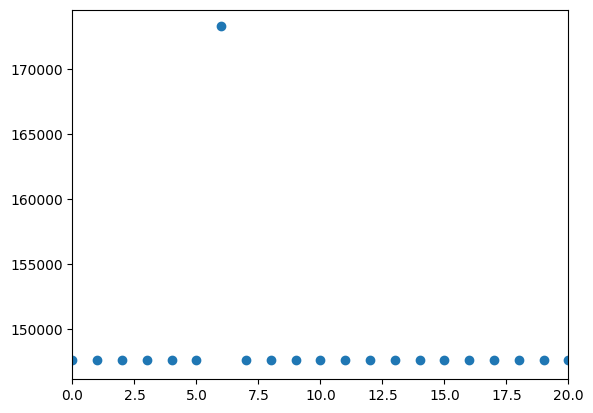

In [35]:
plt.scatter(range(len(loss_sum)), loss_sum)
plt.xlim(0,20)

In [208]:
with open("outputs/4_dict_opt_save_pso_NOPCA_STD.pkl", 'rb') as f:
    data = pickle.load(f)
    mu = []
    i = 0
    for _, dict_values in data.items():
        i+=1
        print(i)
        list_mu = dict_values["list_mu"]
        mu.append(list_mu)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


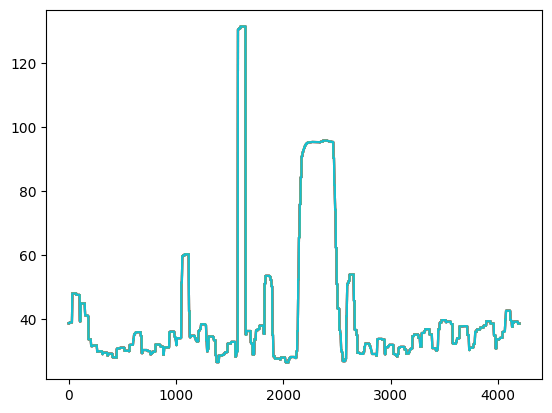

In [24]:
sum_loss = []
for i in range(len(total_loss_pso)):
    if (np.sum(total_loss_pso[i]) > 170000):
        plt.plot(total_loss_pso[i])

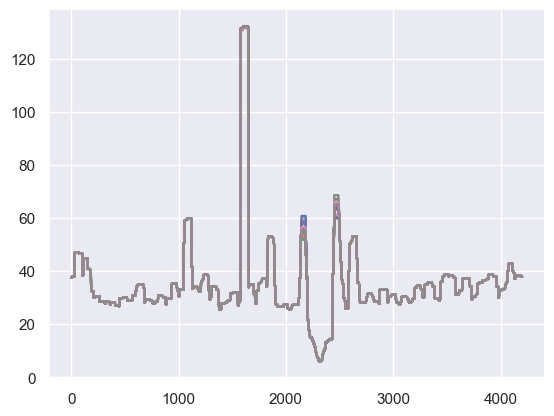

In [170]:
sum_loss = []
for i in range(len(total_loss_all)):
    if (np.sum(total_loss_all[i]) < 170000) and (i < 30):
        plt.plot(total_loss_all[i])

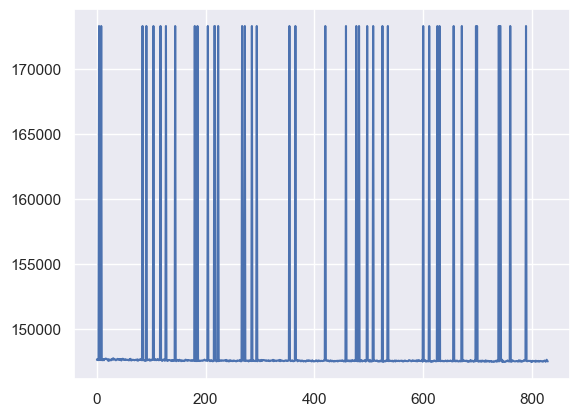

In [167]:
plt.plot(sum_loss)

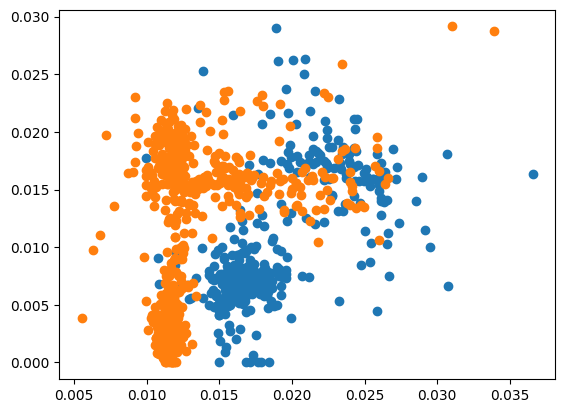

In [115]:
mu0 = [mu_single[0] for mu_single in mu]
mu1 = [mu_single[1] for mu_single in mu]
mu2 = [mu_single[-6] for mu_single in mu]
mu3 = [mu_single[-4] for mu_single in mu]
plt.scatter(mu0, mu1)
plt.scatter(mu2, mu3)

1


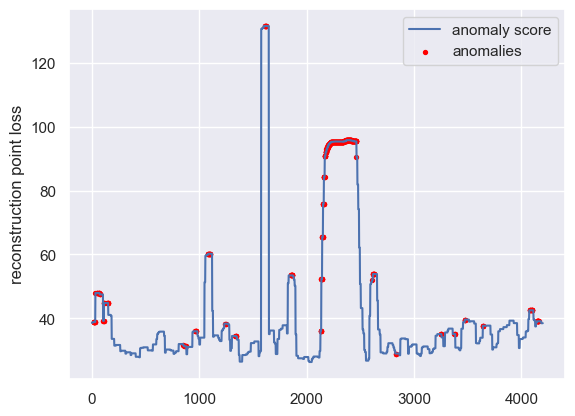

In [160]:
import seaborn as sns
#with open("outputs/2_dict_opt_save_NOPCA_STD.pkl", 'rb') as f:
i = 0
dict_values = data[4]
i+=1
print(i)
labels1 = np.where(labels == 1)[0]

loss_ts = dict_values["loss_ts"]
total_loss = upscale_signal(loss_ts, labels.shape[0], stride, window_size, operator=np.maximum)
labels1_value_loss = total_loss[labels1] 
sns.set()
plt.plot(total_loss, label = "anomaly score")
threshold = np.mean(total_loss) - 0.18*np.std(total_loss)
#plt.axhline(y=threshold, color='orange', linestyle='-', label = "threshold")
plt.scatter(labels1, labels1_value_loss, s = 8, color='red', label = "anomalies")
plt.ylabel("reconstruction point loss")
plt.legend()
predicted_labels = total_loss > threshold
evaluator = TSEvaluator(alpha_recall = 0)
recall = evaluator.get_recall(labels, predicted_anomalies = predicted_labels)
precision = evaluator.get_precision(labels, predicted_anomalies= predicted_labels)
evaluator = TSEvaluator(alpha_recall = 1)
recall_1 = evaluator.get_recall(labels, predicted_labels )


In [156]:
recall, recall_1, precision

(0.7570330167345092, 0.7575757575757576, 0.1361413043478261)

<BarContainer object of 51 artists>

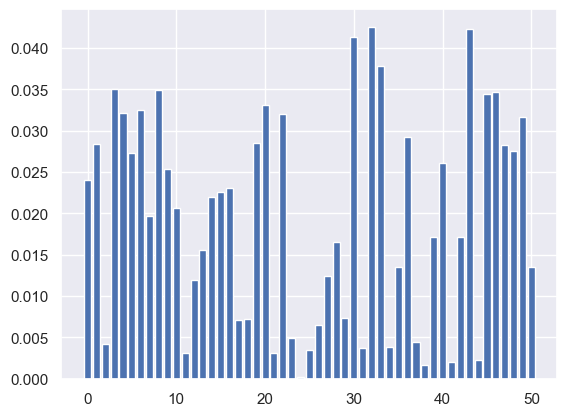

In [180]:
plt.bar(range(51), data[820]['list_mu'])

(16330.0, 16355.0)

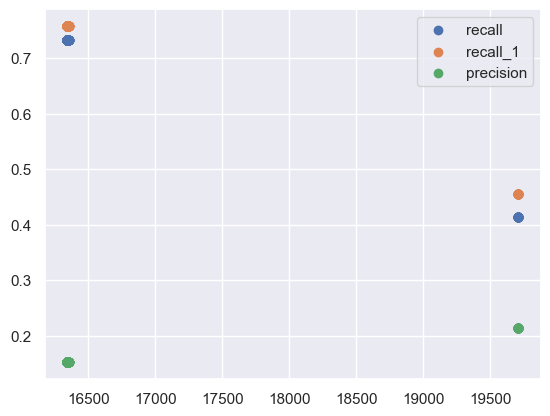

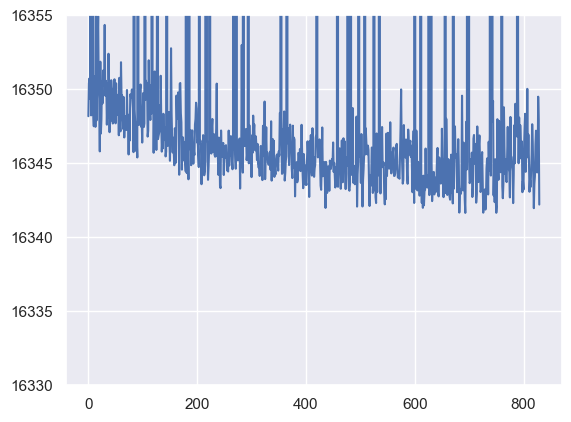

In [161]:
loss = [x[0] for x in loss_accuracy_ga]
recall = [x[1] for x in loss_accuracy_ga]
recall_1 = [x[2] for x in loss_accuracy_ga]
precision = [x[3] for x in loss_accuracy_ga]

plt.scatter(loss, recall, label = "recall")
plt.scatter(loss, recall_1, label = "recall_1")
plt.scatter(loss, precision, label = "precision")
plt.legend()
plt.figure()
plt.plot(loss)
plt.ylim(16330,16355)

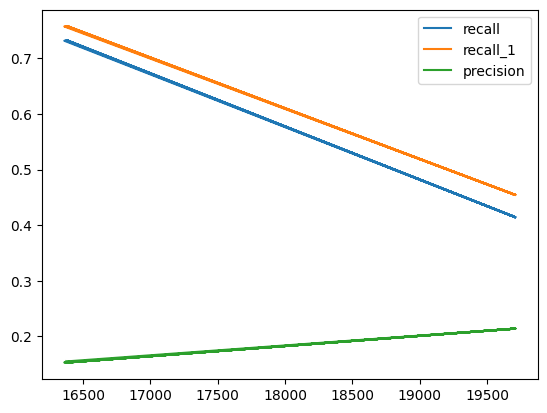

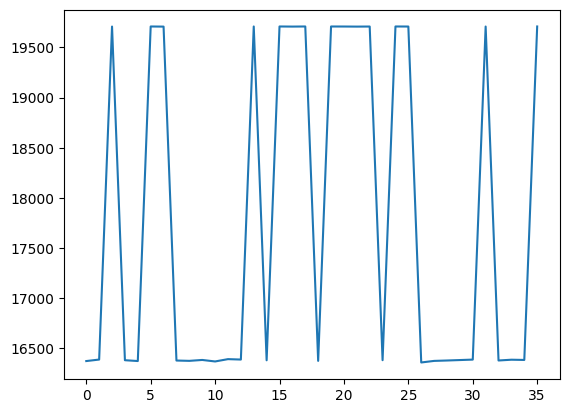

In [98]:
loss_accuracy = loss_accuracy_normal
loss = [x[0] for x in loss_accuracy]
recall = [x[1] for x in loss_accuracy]
recall_1 = [x[2] for x in loss_accuracy]
precision = [x[3] for x in loss_accuracy]

plt.plot(loss, recall, label = "recall")
plt.plot(loss, recall_1, label = "recall_1")
plt.plot(loss, precision, label = "precision")
plt.legend()
plt.figure()
plt.plot(loss)

In [141]:
plt.scatter(range(int(len(recall[:10]))), recall[:10])

TypeError: 'float' object is not subscriptable

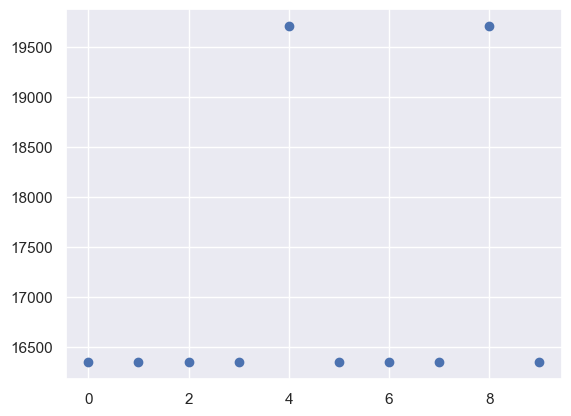

In [142]:
loss = [x[0] for x in loss_accuracy_ga]
plt.scatter(range(int(len(loss[:10]))), loss[:10])

In [80]:
####

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4965 sha256=b9ecef2c54a166e967063275df6d04dcae093ab7a95a1cf5f6c904732e2b5e35
  Stored in directory: c:\users\paulc\appdata\local\pip\cache\wheels\0c\39\12\4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### PAPER DATASET

In [2]:
import pandas as pd
df = pd.read_csv("data/air_quality/AirQualityUCI.csv")


In [3]:
df.columns

Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH', 'CO_level'],
      dtype='object')

In [4]:
columns_kept = ['PT08_S3_Nox', 'PT08_S4_NO2',
       'PT08_S5_O3']

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns_kept])

In [10]:
df_reduced = df_scaled[:8000]

window_size = 10

stride = 2
sequences = generate_subsequences(df_reduced, window_size, stride)
#label_sequences = generate_subsequences(df["CO_level"].values.reshape(-1,1)[:8000], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  10
stride =  2


In [11]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
#data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

In [14]:
mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    3, # N cluster
    2, # fuzzy coef
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [15]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


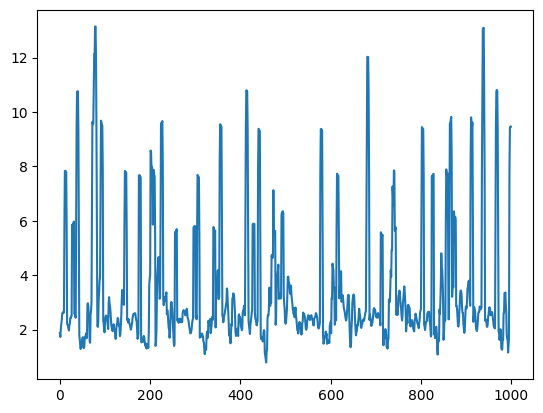

In [16]:
plt.plot(loss[2000:3000])

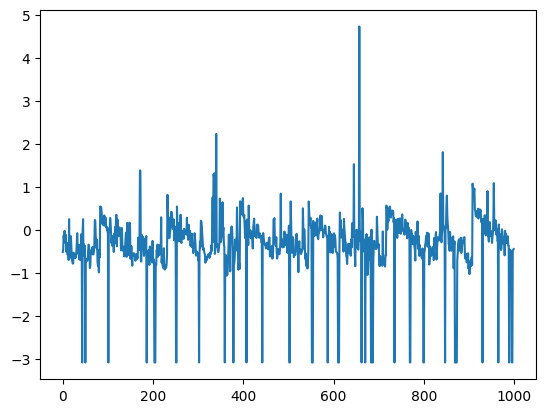

In [17]:
plt.plot(df_scaled[2000:3000,0])

In [19]:
optimizer = opt(
    N_cluster=3,
    data=data_for_clustering,
    window_size=10,
    ga_opt_parameters=[],
)

In [25]:
optimizer.run_pso(max_iter=10, num_particles = 20, initial_particles = [50,100])


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
fitness_pso = optimizer.fitness_pso
solution_pso = optimizer.solution_pso

In [24]:
solution_pso/np.sum(solution_pso)

array([0.34360285, 0.325382  , 0.33101515])